# Introduction to Machine Learning: the Naive Bayes Classifier

Naive Bayes is a simple technique for constructing classifiers: models that assign class labels to problem instances, represented as vectors of feature values. There is not a single algorithm for training such classifiers, but a family of algorithms based on a common principle: all naive Bayes classifiers assume that the value of a particular feature is independent of the value of any other feature, given the class variable. For instance, if we want to describe an apple, features such as  color or shape would be considered independent from the fruit and with different probability distributions. In this workshop, we will explore two major algorithms for training a Naive Bayes classifier: the Gaussian Naive Bayes and the MultinomialNaive Baayes (there are others, of course).

Abstractly, naive Bayes is a conditional probability model: given a problem instance to be classified, represented by a vector $x =(x_{1},\dots ,x_{n})$, representing some *N* features or pieces of evidence (independent variables), it assigns to this instance probabilities

$Pr( C_k | x_1, x_2,..., x_N)$

for each of K possible outcomes or classes, $C_K$.

The problem with the above formulation is that if the number of features n is large or if a feature can take on a large number of values, then basing such a model on probability tables is infeasible. We therefore reformulate the model to make it more tractable. Using Bayes' theorem, the conditional probability can be decomposed as

$ Pr( C | x_1, x_2, ..., x_N ) = \frac{Pr(C) Pr(x_1, x_2, ..., x_N | C)}{Pr( x_1, x_2, ..., x_N)} $

In plain English, using Bayesian probability terminology, the above equation can be written as

$ posterior = \frac{ prior x likelihood }{evidence} $

## A General Machine Learning Architecture

<img src="images/ML.png" width="700px">

## Task A: A Breast Cancer Classifier Using Naive Bayes

In this workshop, we will be applying Naive Bayes to try to predict if some tumor is malignant (cancer) or benign. 

### Import the Required Libraries

In [2]:
# Numerical Data Manipulation libraries
import pandas as pd
import numpy as np
import statistics as stat

# Figure Plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set()

# Naive Bayes libraries
import sklearn
from sklearn.naive_bayes import BernoulliNB      # Naive Bayes Classifier based on a Bernoulli Distribution
from sklearn.naive_bayes import GaussianNB       # Naive Bayes Classifier based on a Gaussian Distribution
from sklearn.naive_bayes import MultinomialNB    # Naive Bayes Classifier based on a Multinomial Distribution

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Text Analysis libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

### Some Functions



In [2]:
# function to plot gaussian distribution in data
def func_plot_gaussian( data, ylim, xlim ):
   # xlim = (5, 40)
   # ylim = (5, 30)

    # separate the benign tumours (diagnosis = 0) from the malignant ones (diagnosis = 1)
    mal = data[ data[ 'diagnosis'] == 1]
    ben = data[ data[ 'diagnosis'] == 0]

    # need to convert dataframe into a matrix in order to make the plot work
    X = data[ ['radius_mean', 'texture_mean'] ]
    x = X.to_numpy()

    # plot figure
    fig=plt.figure()
    ax= fig.add_subplot(111)
    
    plt.scatter(mal['radius_mean'], mal['texture_mean'], c='r', marker='s', s=3, label='malignant')
    plt.scatter(ben['radius_mean'], ben['texture_mean'], c='b', marker='o', s=3, label='benign')
    plt.ylabel('texture_mean', fontsize=12)
    plt.xlabel('radius_mean', fontsize=12)
    plt.title('Breast Tumors', fontsize=14)
    plt.legend()

    xg = np.linspace(xlim[0], xlim[1], 60)
    yg = np.linspace(ylim[0], ylim[1], 40)
    xx, yy = np.meshgrid(xg, yg)
    Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

    for label, color in enumerate(['blue', 'red']):
        mask = (y == label)
        mu, std = x[mask].mean(0), x[mask].std(0)
        P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
        Pm = np.ma.masked_array(P, P < 0.05)
        ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5, cmap=color.title() + 's')
        ax.contour(xx, yy, P.reshape(xx.shape), levels=[0.01, 0.1, 0.5, 0.9], colors=color, alpha=0.2) 
    
    ax.set(xlim=xlim, ylim=ylim)
    fig.show()
    return

### The Dataset

In [3]:
# Load breast cancer dataset
# Data describes if a tumour is MALIGNANT (value 1) or BENIGN (value 0) accordong to:
# - mean radius of the tumour
# - mean texture of the tumour
file_path = 'data/breast_data_simple.csv'
data = pd.read_csv( file_path )

In [4]:
data

,diagnosis,radius_mean,texture_mean
0,1,17.990,10.38
1,1,20.570,17.77
2,1,19.690,21.25
3,1,11.420,20.38
4,1,20.290,14.34
5,1,12.450,15.70
6,1,18.250,19.98
7,1,13.710,20.83
8,1,13.000,21.82
9,1,12.460,24.04


In [5]:
# separate your dataset: 
# put the variable that you wish to classify (or predict) in one variable
# put your sources of evidence (or your features) in another variable
y = data['diagnosis']                        # variable to classify and preduict
X = data[['radius_mean', 'texture_mean']]    # variable containing your features

Before we proceed with any data analysis, we need to try to understand what kind of data are we dealing with. 
Naive Bayes model (like most machine learning models) are based on statistical analysis. This means that the distribution of your data plays an important role in how the machine learning algorithm should address it. 

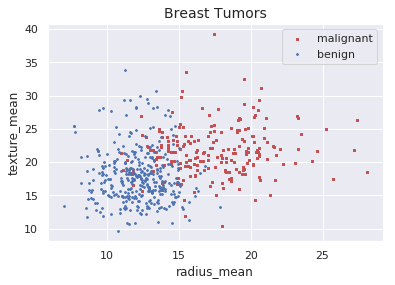

In [6]:
# for plotting purposes:
# separate the benign tumors (diagnosis = 0) from the malignant ones (diagnosis = 1)
malignant = data[ data[ 'diagnosis'] == 1]
benign = data[ data[ 'diagnosis'] == 0]

# need to convert dataframe into a matrix in order to make the plot work
x = X.to_numpy()

# plot figure
fig=plt.figure()

plt.scatter(malignant['radius_mean'], malignant['texture_mean'], c='r', marker='s', s=3, label='malignant')
plt.scatter(benign['radius_mean'], benign['texture_mean'], c='b', marker='o', s=3, label='benign')
plt.ylabel('texture_mean', fontsize=12)
plt.xlabel('radius_mean', fontsize=12)
plt.title('Breast Tumors', fontsize=14)
plt.legend()
plt.show()

Our dataset is not sparse, which is good (it is hard to model sparse data). The data sems to be concentric and to deviate around a mean value. In statistics and machine learning, we usually represent data with a Gaussian Distribution (which is nothing more than a bell shaped curve). Let's see this in our data:

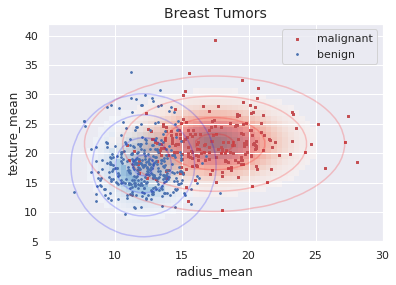

In [7]:
# plotting function defined in the begining of the notebook
func_plot_gaussian( data, (5, 42), (5, 30) )

### Running the Naive Bayes Classifier with a Gaussian Kernel

#### The Importance of Defining Test and Training Sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Definition of the Type of Classifier

In [9]:
GaussNB = GaussianNB()
GaussNB.fit(X_train, y_train)
print(GaussNB)

y_prediction = GaussNB.predict(X_test)
print( 'The overall accuracy of the model is ' + str(accuracy_score( y_test, y_prediction )))

GaussianNB(priors=None, var_smoothing=1e-09)
The overall accuracy of the model is 0.847953216374269


#### Validating Results

In [10]:
trials = 500

accuracy = [None] * trials
for trial in range( 0, trials ):
    
    # randomly select a test set and a training set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    y_expected = y_test
    
    GaussNB = GaussianNB()                     # create the Gaussian Naive Bayes Classifer
    GaussNB.fit(X_train, y_train)              # fit the model to the training data

    y_predicted = GaussNB.predict(X_test)                       # get predictions of model on the test set
    accuracy[trial] = accuracy_score( y_expected, y_predicted ) # save accuracy obtained in each trial
    print("Applying Naive Bayes............................ Trial #" + str(trial + 1) + " ....... acc = " + str( accuracy[trial] ))


Applying Naive Bayes............................ Trial #1 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #2 ....... acc = 0.8596491228070176
Applying Naive Bayes............................ Trial #3 ....... acc = 0.9122807017543859
Applying Naive Bayes............................ Trial #4 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #5 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #6 ....... acc = 0.8713450292397661
Applying Naive Bayes............................ Trial #7 ....... acc = 0.847953216374269
Applying Naive Bayes............................ Trial #8 ....... acc = 0.8947368421052632
Applying Naive Bayes............................ Trial #9 ....... acc = 0.847953216374269
Applying Naive Bayes............................ Trial #10 ....... acc = 0.8596491228070176
Applying Naive Bayes............................ Trial #11 ....... acc = 0.847953216374269


Applying Naive Bayes............................ Trial #93 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #94 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #95 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #96 ....... acc = 0.8596491228070176
Applying Naive Bayes............................ Trial #97 ....... acc = 0.9064327485380117
Applying Naive Bayes............................ Trial #98 ....... acc = 0.9181286549707602
Applying Naive Bayes............................ Trial #99 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #100 ....... acc = 0.9005847953216374
Applying Naive Bayes............................ Trial #101 ....... acc = 0.8538011695906432
Applying Naive Bayes............................ Trial #102 ....... acc = 0.8947368421052632
Applying Naive Bayes............................ Trial #103 ....... acc = 0.8

Applying Naive Bayes............................ Trial #185 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #186 ....... acc = 0.8947368421052632
Applying Naive Bayes............................ Trial #187 ....... acc = 0.9005847953216374
Applying Naive Bayes............................ Trial #188 ....... acc = 0.8830409356725146
Applying Naive Bayes............................ Trial #189 ....... acc = 0.8947368421052632
Applying Naive Bayes............................ Trial #190 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #191 ....... acc = 0.8830409356725146
Applying Naive Bayes............................ Trial #192 ....... acc = 0.8830409356725146
Applying Naive Bayes............................ Trial #193 ....... acc = 0.8654970760233918
Applying Naive Bayes............................ Trial #194 ....... acc = 0.8830409356725146
Applying Naive Bayes............................ Trial #195 ....... ac

Applying Naive Bayes............................ Trial #277 ....... acc = 0.8713450292397661
Applying Naive Bayes............................ Trial #278 ....... acc = 0.8830409356725146
Applying Naive Bayes............................ Trial #279 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #280 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #281 ....... acc = 0.9122807017543859
Applying Naive Bayes............................ Trial #282 ....... acc = 0.9064327485380117
Applying Naive Bayes............................ Trial #283 ....... acc = 0.9122807017543859
Applying Naive Bayes............................ Trial #284 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #285 ....... acc = 0.8830409356725146
Applying Naive Bayes............................ Trial #286 ....... acc = 0.8654970760233918
Applying Naive Bayes............................ Trial #287 ....... ac

Applying Naive Bayes............................ Trial #369 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #370 ....... acc = 0.8713450292397661
Applying Naive Bayes............................ Trial #371 ....... acc = 0.8654970760233918
Applying Naive Bayes............................ Trial #372 ....... acc = 0.8713450292397661
Applying Naive Bayes............................ Trial #373 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #374 ....... acc = 0.8654970760233918
Applying Naive Bayes............................ Trial #375 ....... acc = 0.847953216374269
Applying Naive Bayes............................ Trial #376 ....... acc = 0.9064327485380117
Applying Naive Bayes............................ Trial #377 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #378 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #379 ....... acc

Applying Naive Bayes............................ Trial #459 ....... acc = 0.8362573099415205
Applying Naive Bayes............................ Trial #460 ....... acc = 0.8947368421052632
Applying Naive Bayes............................ Trial #461 ....... acc = 0.8713450292397661
Applying Naive Bayes............................ Trial #462 ....... acc = 0.8596491228070176
Applying Naive Bayes............................ Trial #463 ....... acc = 0.8947368421052632
Applying Naive Bayes............................ Trial #464 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #465 ....... acc = 0.9064327485380117
Applying Naive Bayes............................ Trial #466 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #467 ....... acc = 0.8538011695906432
Applying Naive Bayes............................ Trial #468 ....... acc = 0.9064327485380117
Applying Naive Bayes............................ Trial #469 ....... ac

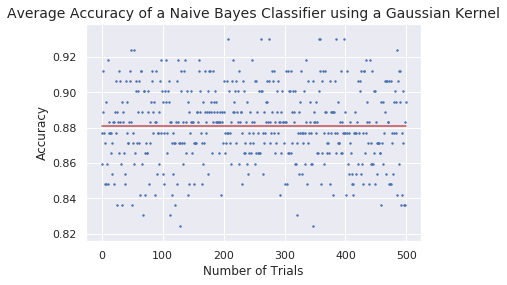

Average model accuracy is 0.8810292397660818


In [11]:
# Computute overall average accuracy
avg_accuracy = stat.mean( accuracy )

# plot results
plt.figure()
plt.scatter( range( 0, trials ), accuracy, s = 2 )
lst = np.ones(trials, float)
plt.plot( range( 0, trials ), avg_accuracy*lst, c='r' )
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Number of Trials', fontsize=12)
plt.title('Average Accuracy of a Naive Bayes Classifier using a Gaussian Kernel', fontsize=14)
plt.show()

print( "Average model accuracy is " +  str( avg_accuracy ) )

#### What if we use a Bernoulli distribution?

In [12]:
BernNB = BernoulliNB()
BernNB.fit(X_train, y_train)
print(BernNB)

y_prediction = BernNB.predict(X_test)
print( 'The overall accuracy of the model is ' + str(accuracy_score( y_test, y_prediction )))

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
The overall accuracy of the model is 0.6140350877192983


What happen to the performance of our classifier? How can you justify this?

## Try it Yourself! Breast Cancer classification with more features

In [3]:
# Load your dataset
file_path = 'data/breast_data_full.csv'
data_full = pd.read_csv( file_path )

In [ ]:
# what are the features in this dataset? How many are there?

# YOUR CODE HERE:


In [9]:
# separate your dataset: 
# put the variable that you wish to classify (or predict) in one variable
# put your sources of evidence (or your features) in another variable

# note that your dataset contains a column id, which is not necessary. 
# hint: use Python's .loc method to try to sellect the columns that you want to use for your analysis

# YOUR CODE HERE:



In [11]:
# separate the dataset into test set and train set

# YOUR CODE HERE:


In [12]:
# Define the NaiveBayes Gaussian kernel
# Fit a model to the data
# Use the learned model to try to predict the tumors on the testset
# Measure the overall accuracy of the model


# YOUR CODE HERE:


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
The overall accuracy of the model is 0.8830409356725146


### Comments
What were your findings? Did the incorporation of more features have any impact on the predictions?

## Using Naive Bayes in Text Classification

In [13]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [14]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']
#categories = data.target_names

train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

With any of the preceding examples, it can quickly become tedious to do the transformations by hand, especially if you wish to string together multiple steps. For example, we might want a processing pipeline that looks something like this:

Impute missing values using the mean
Transform features to quadratic
Fit a linear regression
To streamline this type of processing pipeline, Scikit-Learn provides a Pipeline object, which can be used as follows

In [15]:
# define test and training sets
X_train_raw = train.data
y_train = train.target

X_test_raw = test.data
y_test = test.target
y_expected = test.target

In [26]:
print(X_train_raw[1])

From: MANDTBACKA@finabo.abo.fi (Mats Andtbacka)
Subject: Re: If There Were No Hell
Organization: Unorganized Usenet Postings UnInc.
Lines: 26

In <May.5.02.51.25.1993.28737@athos.rutgers.edu> shellgate!llo@uu4.psi.com writes:

> Here's a question that some friends and I were debating last night.
> Q: If you knew beyond all doubt that hell did not exist and that
>    unbelievers simply remained dead, would you remain a Christian?

      (Reasoning pertinent to believing Xians deleted for space)

      It strikes me, for no apparent reason, that this is reversible.
I.e., if I had proof that there existed a hell, in which I would be
eternally punished for not believing in life, would that make me a Xian?
(pardon my language) _Bloody_hell_no_!

      ...Of course, being merely a reversal of your thinking, this
doesn't add anything _new_ to the debate, but...

> Several friends disagreed, arguing the fear of hell was necessary
> to motivate people to Christianity. To me that fatally undercu

In [16]:
# Extract Tf.Idf features from text
vec = TfidfVectorizer()
X_train = vec.fit_transform( X_train_raw )
X_test = vec.fit_transform( X_test_raw )

The overall accuracy of the model is 0.8016759776536313


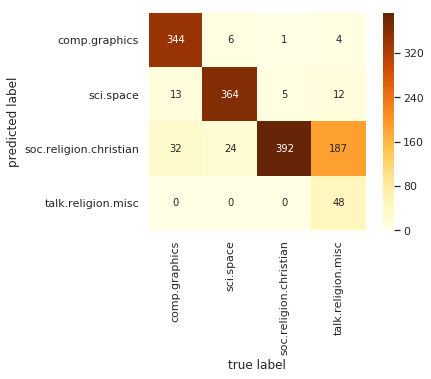

In [17]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(train.data, train.target)
labels = model.predict(test.data)

print( 'The overall accuracy of the model is ' + str(accuracy_score( y_expected, labels )))

colormap = "YlOrBr" # more colors can be found here: https://matplotlib.org/tutorials/colors/colormaps.html
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap = colormap,
            xticklabels=train.target_names, yticklabels=train.target_names)

plt.xlabel('true label')
plt.ylabel('predicted label');

#### testing different sentences

In [19]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [20]:
predict_category('Teaching data analytics with really nice graphics')

'comp.graphics'

In [21]:
predict_category('Flat earth people say Australia does not exist and we are all being paid by Nasa')

'soc.religion.christian'

In [27]:
predict_category('Chef Kiko is opening a restaurant in Mars')

'sci.space'

In [ ]:
predict_category('discussing islam vs atheism')